# Auto-Keras, the Open Source Neural Architecture Search 
Website: https://autokeras.com/ Citation: arXiv:1806.10282 Paper: https://arxiv.org/abs/1806.10282

(Version 0.2.13 as of 9/8/18)

In [5]:
from autokeras.image_supervised import ImageClassifier, load_image_dataset

## Loading the Images and Labels

Images should be squares. To avoid tedious errors, they should also be either gray scale (1 color channel) or sRGB (3 color channels).

The labels are in a .csv file with the format

img0, 0 <br>
img1, 1 <br>
img2, 1 <br>
img3, 2 <br>
. <br>
. <br>
. <br>
imgN, 0

In [6]:
train_path = 'datasets/dogsCats/dogCat128rgb_train'
train_labels = 'datasets/dogsCats/dogsCats_train.csv'

validation_path = 'datasets/dogsCats/dogCat128rgb_val'
validation_labels = 'datasets/dogsCats/dogsCats_val.csv'

from os import listdir
from os.path import isfile, join
files = [f for f in listdir(train_path) if isfile(join(train_path,f))]
print(files)

['cat.5752.jpg', 'dog.5065.jpg', 'dog.16.jpg', 'cat.6713.jpg', 'dog.2127.jpg', 'dog.5438.jpg', 'dog.7207.jpg', 'cat.1498.jpg', 'dog.8985.jpg', 'cat.8442.jpg', 'cat.7507.jpg', 'dog.5344.jpg', 'cat.2486.jpg', 'dog.7308.jpg', 'cat.7849.jpg', 'cat.1911.jpg', 'dog.130.jpg', 'cat.2620.jpg', 'cat.9039.jpg', 'dog.8089.jpg', 'cat.3596.jpg', 'dog.6548.jpg', 'dog.7521.jpg', 'dog.3309.jpg', 'dog.224.jpg', 'dog.3735.jpg', 'cat.6317.jpg', 'cat.5135.jpg', 'dog.1140.jpg', 'dog.9497.jpg', 'cat.1079.jpg', 'cat.573.jpg', 'dog.8121.jpg', 'dog.5358.jpg', 'cat.5209.jpg', 'cat.3022.jpg', 'cat.5948.jpg', 'cat.2570.jpg', 'cat.4573.jpg', 'dog.4422.jpg', 'cat.4512.jpg', 'cat.6100.jpg', 'cat.8247.jpg', 'cat.863.jpg', 'dog.5679.jpg', 'dog.8508.jpg', 'dog.4047.jpg', 'cat.5756.jpg', 'dog.82.jpg', 'dog.2170.jpg', 'dog.5996.jpg', 'dog.1057.jpg', 'cat.2433.jpg', 'cat.3853.jpg', 'cat.6873.jpg', 'cat.8939.jpg', 'cat.3562.jpg', 'dog.1525.jpg', 'dog.280.jpg', 'cat.1278.jpg', 'cat.4498.jpg', 'dog.7282.jpg', 'cat.4186.jpg', 

## Using load_image_dataset for Your Own Image Dataset (arguably the hardest part)
All images of `x_train` should be the same height and same width and have same color channels to each other.
The shape of `x_train[0]` and `y_train[0]` should be the same as they both represent the amount of samples.

Similarly, images in `x_val` should have the same height and same width and have same color channels to each other.
The shape of `x_val[0]` and `y_val[0]` should be the same as they both represent the amount of samples.

The .csv file does not have to be in the same order in which the image files are arranged (the images may not be read in order to begin with); you should be fine so long as an image exists in the image path provided and its name is somewhere in the csv file along with its label.

Use ImageMagick if you have trouble formatting your images! https://www.imagemagick.org/script/index.php

In [7]:
x_train, y_train = load_image_dataset(csv_file_path=train_labels,
                                    images_path=train_path)
print(x_train.shape)
print(y_train.shape)

x_val, y_val = load_image_dataset(csv_file_path=validation_labels,images_path=validation_path)

print(x_val.shape)
print(y_val.shape)

(20000, 128, 128, 3)
(20000,)
(5000, 128, 128, 3)
(5000,)


## Searching for the Best Model
These models can get large, and exponentially get larger as the image sizes get larger. 
Thus, it is best to scale your images smaller (e.g. 32x32, 64x64, 128x128) to avoid receiving the error: __RuntimeError: CUDA error: out of memory__. This is also good practice to deal with the Curse of Dimensionality.

Furthermore, you should consider letting `fit()` run for several hours to avoid receiving the error: __TimeoutError: Search Time too short. No model was found during the search time__. I personally feel that `max_iter_num` should be at least 25. Otherwise, any candidate model will have limited training time before the Searcher searches for another model. Auto-Keras will train the model up to `max_iter_num` or if no incremental loss is being made after 5 epochs (whichever one comes first) before training another candidate model.

In [8]:
clf = ImageClassifier(verbose = True, searcher_args = {'trainer_args':{'max_iter_num': 25}})
clf.fit(x_train,y_train, time_limit = 4 * 60 * 60) # default time_limit is 24 hours 


Initializing search.
Initialization finished.


╒==============================================╕
|               Training model 0               |
╘==============================================╛

Saving model.
+--------------------------------------------------------------------------+
|        Model ID        |          Loss          |      Metric Value      |
+--------------------------------------------------------------------------+
|           0            |   6.727340366505087    |   0.8196760647870425   |
+--------------------------------------------------------------------------+


╒==============================================╕
|               Training model 1               |
╘==============================================╛

+--------------------------------------------------------------------------+
|    Father Model ID     |                 Added Operation                 |
+--------------------------------------------------------------------------+
|                      


+--------------------------------------------------------------------------+
|    Father Model ID     |                 Added Operation                 |
+--------------------------------------------------------------------------+
|                        |          ('to_conv_deeper_model', 1, 3)         |
|                        |          ('to_conv_deeper_model', 1, 3)         |
|                        |          ('to_conv_deeper_model', 5, 3)         |
|                        |          ('to_conv_deeper_model', 9, 3)         |
|                        |           ('to_add_skip_model', 1, 18)          |
|                        |          ('to_add_skip_model', 18, 24)          |
|           3            |          ('to_add_skip_model', 24, 27)          |
|                        |          ('to_conv_deeper_model', 1, 3)         |
|                        |         ('to_concat_skip_model', 21, 24)        |
|                        |         ('to_conv_deeper_model', 24, 3)         

RuntimeError: CUDA error: out of memory

## Fitting the Best Model Found During Search
NOTE: In Jupyter Notebooks, even if the program crashes during the search process, `final_fit()` will still evaluate the best model amongst the models that were searched before the crash (i.e. `final_fit()` will still run as intended, but with probably fewer models). This process may take several minutes.

Setting the *retrain* boolean to `True` will maintain the architecture of the model with the highest accuracy, but will reset its weights. Setting it to `False` will not only maintain the architecture but effectively resume its training with the weights it learned during `fit()`


In [9]:
clf.final_fit(x_train,y_train,x_val,y_val,retrain = True, trainer_args={'max_iter_num':10})

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


+--------------------------------------------------------------------------+
|         Epoch          |          Loss          |        Accuracy        |
+--------------------------------------------------------------------------+
|           1            |   21.747949361801147   |         0.7206         |
+--------------------------------------------------------------------------+


Widget Javascript not detected.  It may not be installed or enabled properly.


|           2            |   20.670410752296448   |         0.7504         |
+--------------------------------------------------------------------------+


Widget Javascript not detected.  It may not be installed or enabled properly.


|           3            |   18.211566030979156   |         0.7878         |
+--------------------------------------------------------------------------+


Widget Javascript not detected.  It may not be installed or enabled properly.


|           4            |   17.797655165195465   |         0.798          |
+--------------------------------------------------------------------------+


Widget Javascript not detected.  It may not be installed or enabled properly.


|           5            |   16.10536528378725    |         0.8132         |
+--------------------------------------------------------------------------+


Widget Javascript not detected.  It may not be installed or enabled properly.


|           6            |   14.692404478788376   |         0.8388         |
+--------------------------------------------------------------------------+


Widget Javascript not detected.  It may not be installed or enabled properly.


|           7            |   15.419847458600998   |         0.8266         |
+--------------------------------------------------------------------------+


Widget Javascript not detected.  It may not be installed or enabled properly.


|           8            |   16.230876356363297   |         0.8206         |
+--------------------------------------------------------------------------+


Widget Javascript not detected.  It may not be installed or enabled properly.


|           9            |   15.254548400640488   |         0.8286         |
+--------------------------------------------------------------------------+


Widget Javascript not detected.  It may not be installed or enabled properly.


|           10           |   15.76220916211605    |         0.8388         |
+--------------------------------------------------------------------------+


## Evaluating the Model

In [10]:
print(clf.evaluate(x_val,y_val))

0.4982


## Loading the Best Model Found

By default, load_best_model() will find the best model based on the metric of highest __accuracy__.

In [11]:
best = clf.load_searcher().load_best_model()
best_torchModel = best.produce_model()
best_kerasModel = best.produce_keras_model()

## More Info about the Best Model Found

In [12]:
print(best.n_layers)

51


In [13]:
print(best_torchModel)

TorchModel(
  (0): ReLU()
  (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): ReLU()
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): ReLU()
  (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): TorchFlatten()
  (13): Dropout2d(p=0.25)
  (14): Linear(in_features=16384, out_features=64, bias=True)
  (15): ReLU()
  (16): Linear(in_features=64, out_features=2, bias=True)
  (17): ReLU()
  (18): Conv2d(64, 6

In [14]:
print(best_kerasModel)

## Saving the Model to be used in other Projects

In [15]:
import torch
torch.save(best.produce_model(),'dogsAndCats_model.pt')
loadedTorchModel = torch.load('dogsAndCats_model.pt')

from keras.models import load_model
best_kerasModel.save('dogsAndCats_model.h5')
loadedKerasModel = load_model('dogsAndCats_model.h5')

## Sanity Check by Visualizing the Model Predictions

In [26]:
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'datasets/dogsCats'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
class_names = ['dog','cat']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

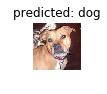

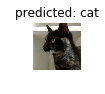

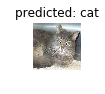

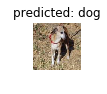

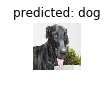

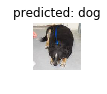

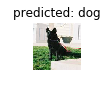

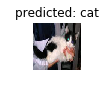

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fcf7c0b6f28>>
Traceback (most recent call last):
  File "/home/jquach12/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/jquach12/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/jquach12/.local/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process

In [30]:
loadedTorchModel = loadedTorchModel.to(device) # allows model to use GPU
visualize_model(loadedTorchModel,8)